In [132]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import os
import harp
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cmcrameri import cm
import geopandas as gpd
from shapely.geometry import Polygon
import branca
import folium
import pyproj

In [82]:
url = "https://s5phub.copernicus.eu/dhus"
api = SentinelAPI('s5pguest', 's5pguest', url)

products = api.query(date=('20230401', '20230409'),
        platformname='Sentinel-5 Precursor',
        producttype='L2__CO____',)

print(f"len={len(products)}")
for product in products.values():
    filename = product['identifier']
    if os.path.exists(os.path.join("./data", filename+".nc")):
        print("skip " + filename)
        continue;
    api.download(product['uuid'], directory_path="./data")


len=15


skip S5P_OFFL_L2__CO_____20230407T235407_20230408T013537_28412_03_020500_20230409T133731


- considering only good quality CO observations: "CO_column_number_density_validity>50"
- keeping the needed parameters: "keep(latitude_bounds,longitude_bounds,CO_column_number_density)"
- regridding the CO data: "bin_spatial(801, -10, 0.05, 1001, -70, 0.05)"
- converting CO to Dobson Units: "derive(CO_column_number_density [DU])"
- derive latitude and longitude coordinates of the new grid: "derive(latitude {latitude})","derive(longitude {longitude})"

In [151]:
def get_regrid_operations():
    operations = ";".join([
        "CO_column_number_density_validity>50",
        "keep(latitude_bounds,longitude_bounds,CO_column_number_density)",
        "bin_spatial(3601, -90, 0.05, 7201, -180, 0.05)",
        #"derive(CO_column_number_density [DU])",
        #"derive(latitude {latitude})",
        #"derive(longitude {longitude})",
        "derive(area {time} [km2])",

    ])
    #"bin_spatial(3601, -90, 0.05, 7201, -180, 0.05)",
    return operations

def get_import_operations():
    operations = ";".join([
        "CO_column_number_density_validity>50",
        "keep(datetime_start,scan_subindex,latitude,longitude,CO_column_number_density)",
        #"derive(CO_column_number_density [DU])",
    ])
    return operations

def get_reduce_operations():
    operations = "squash(time, (latitude, longitude, latitude_bounds, longitude_bounds));bin()"
    return operations

def regrid(filename, operations):
    regridded_product = harp.import_product(filename, operations)
    return regridded_product

def import_product(filename, operations):
    reduced_product = harp.import_product(filename, operations)
    return reduced_product

def save_as_nc(data, filename):
    harp.export_product(data, filename)

def plot_as_pColormesh(gridlon, gridlat, vals, vmin, vmax, colortable, desc, units, save=False, outname=""):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    img = plt.pcolormesh(gridlon, gridlat, vals[0,:,:], vmin=vmin, vmax=vmax,
                            cmap=colortable, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines()

    cbar = fig.colorbar(img, ax=ax,orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(f'{desc}[{units}]')
    cbar.ax.tick_params(labelsize=14)
    if outname:
        plt.title(outname)
    if save:
        plt.savefig(outname+".png")
    else: 
        plt.show()

def plot_as_scatter(lonc, latc, vals, vmin, vmax, colortable, desc, units):


    fig=plt.figure(figsize=(20, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())


    img = plt.scatter(lonc, latc, c=vals,
                    vmin=vmin, vmax=vmax, cmap=colortable, s=1, transform=ccrs.PlateCarree())

    ax.coastlines()

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(f'{desc} [{units}]')
    cbar.ax.tick_params(labelsize=14)
    plt.show()




## Eine Datei plotten

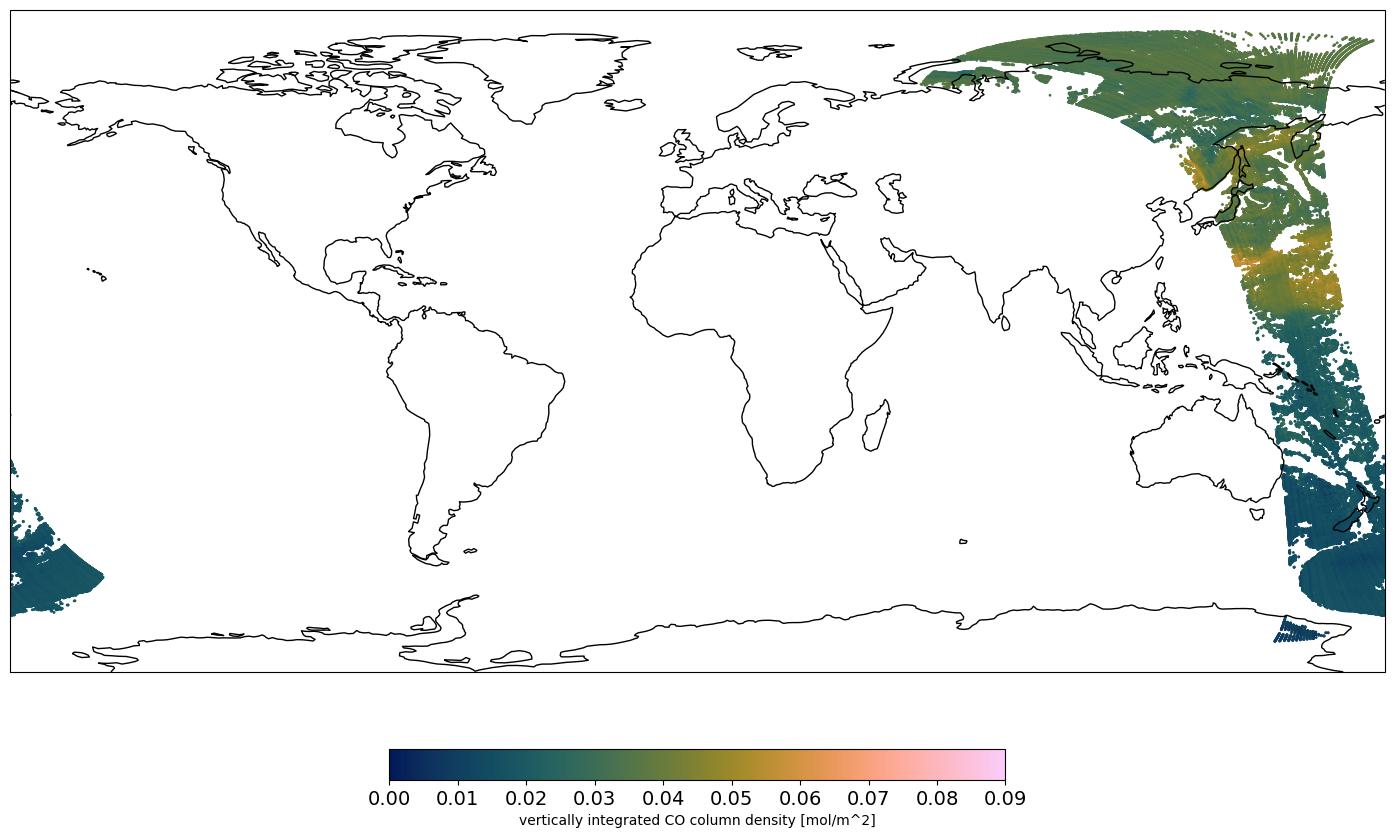

In [149]:
filename = "./data/S5P_OFFL_L2__CO_____20230401T020618_20230401T034748_28314_03_020500_20230402T155156.nc"
operations = get_import_operations()
product = import_product(filename=filename, operations=operations)

vals = product.CO_column_number_density.data
units = product.CO_column_number_density.unit
desc = product.CO_column_number_density.description

latc=product.latitude.data
lonc=product.longitude.data
#print(product)
#print(product.area)


colortable=cm.batlow
# For Dobson Units
vmin=0
vmax=0.09

plot_as_scatter(latc=latc, lonc=lonc, vals=vals, vmin=vmin, vmax=vmax, colortable=colortable, desc=desc, units=units)
#print(product) # time dim in long/ lat

## Eine Datei neu rastern

source product = 'S5P_OFFL_L2__CO_____20230401T020618_20230401T034748_28314_03_020500_20230402T155156.nc'
history = "2023-05-30T18:14:32Z [harp-1.17] harp.import_product('./data/S5P_OFFL_L2__CO_____20230401T020618_20230401T034748_28314_03_020500_20230402T155156.nc',operations='CO_column_number_density_validity>50;keep(latitude_bounds,longitude_bounds,CO_column_number_density);bin_spatial(361, -90, 0.5, 721, -180, 0.5);derive(latitude {latitude});derive(longitude {longitude})')"

double CO_column_number_density {time=1, latitude=360, longitude=720} [mol/m^2]
long count {time=1}
float weight {time=1, latitude=360, longitude=720}
double latitude_bounds {latitude=360, 2} [degree_north]
double longitude_bounds {longitude=720, 2} [degree_east]
double latitude {latitude=360} [degree_north]
double longitude {longitude=720} [degree_east]



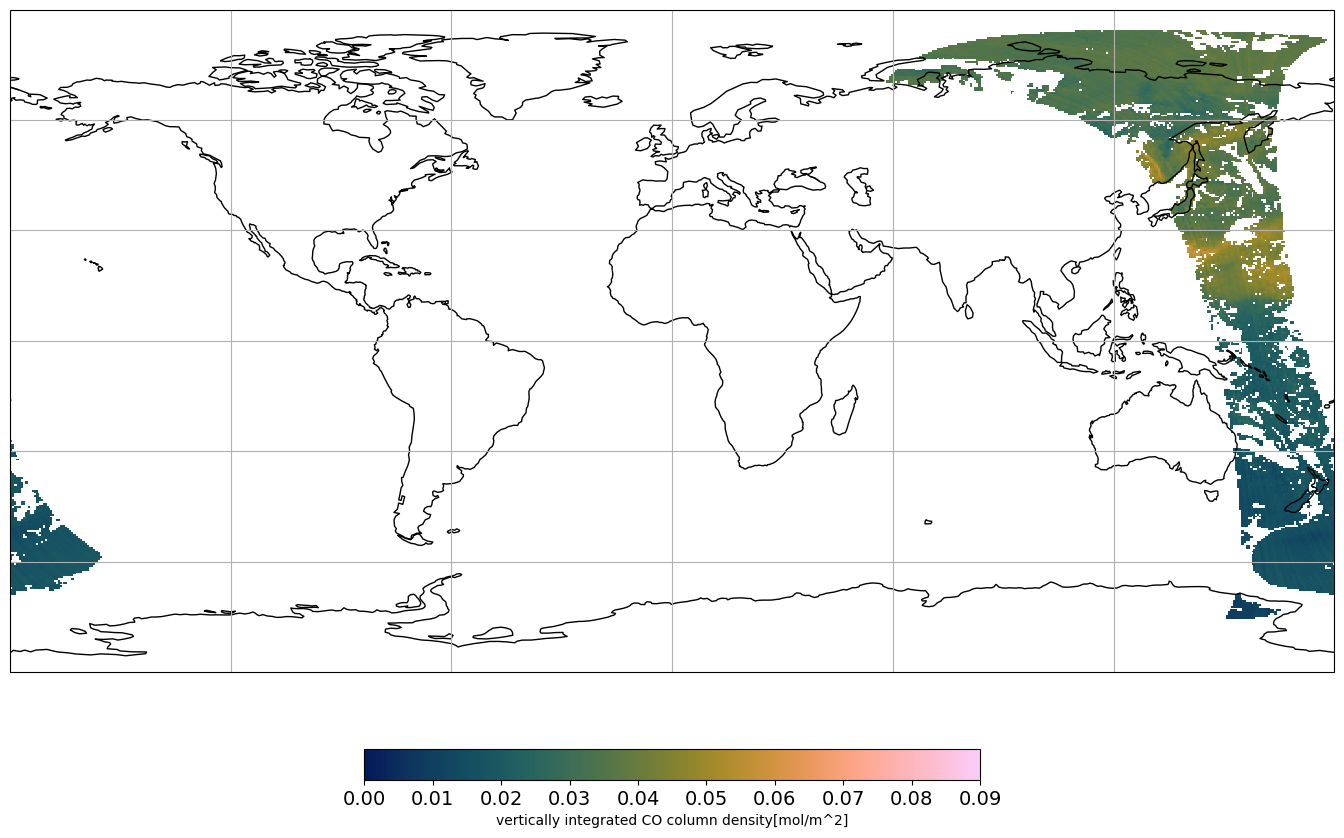

In [167]:
filename = "./data/S5P_OFFL_L2__CO_____20230401T020618_20230401T034748_28314_03_020500_20230402T155156.nc"
operations = ";".join([
    "CO_column_number_density_validity>50",
    "keep(latitude_bounds,longitude_bounds,CO_column_number_density)",
    "bin_spatial(361, -90, 0.5, 721, -180, 0.5)",
    #"derive(CO_column_number_density [DU])",
    "derive(latitude {latitude})",
    "derive(longitude {longitude})",
])

regridded_product = regrid(filename, operations=operations)
gridlat = np.append(regridded_product.latitude_bounds.data[:,0], regridded_product.latitude_bounds.data[-1,1])
gridlon = np.append(regridded_product.longitude_bounds.data[:,0], regridded_product.longitude_bounds.data[-1,1])

vals = regridded_product.CO_column_number_density.data
units = regridded_product.CO_column_number_density.unit
desc = regridded_product.CO_column_number_density.description


colortable=cm.batlow
# For Dobson Units
vmin=0
vmax=0.09
print(regridded_product)

plot_as_pColormesh(gridlat=gridlat, gridlon=gridlon, vals=vals, vmin=vmin, vmax=vmax, colortable=colortable, desc=desc, units=units)

## Gerasterte Level-3 Daten aus mehreren CO-Level-2 Dateien erstellen

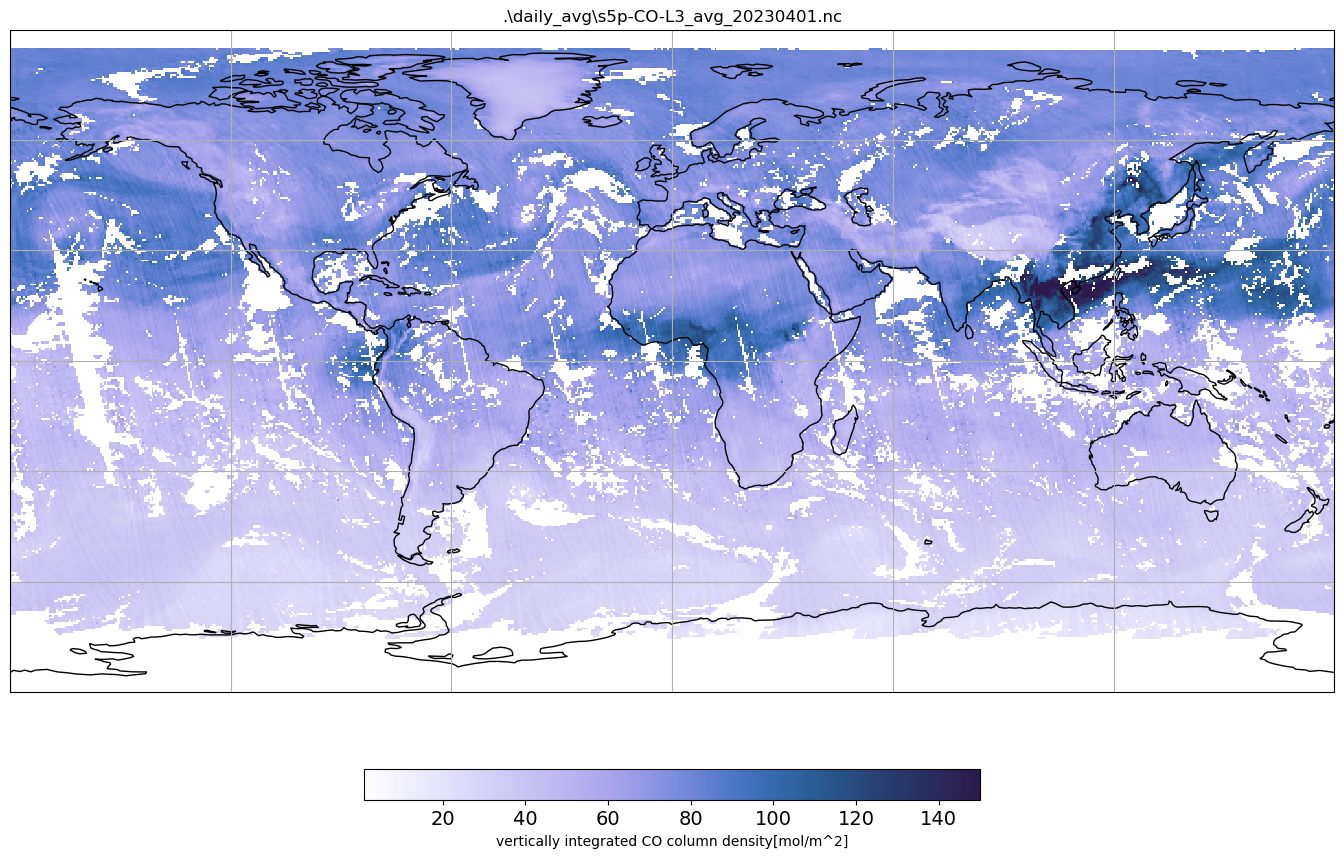

In [85]:
filename_patterns = [
    "./data/S5P_OFFL_L2__CO_____20230401*.nc",
    "./data/S5P_OFFL_L2__CO_____20230402*.nc",
    "./data/S5P_OFFL_L2__CO_____20230403*.nc",
    "./data/S5P_OFFL_L2__CO_____20230404*.nc",
    "./data/S5P_OFFL_L2__CO_____20230405*.nc",
    "./data/S5P_OFFL_L2__CO_____20230406*.nc",
    "./data/S5P_OFFL_L2__CO_____20230407*.nc"
]

def merge_daily_data(filename_pattern):
    outname = str.split(filename_pattern, "/")[2].removesuffix("*.nc").removeprefix("S5P_OFFL_L2__CO_____")
    reduce_operations = "squash(time, (latitude, longitude, latitude_bounds, longitude_bounds));bin()"
    operations = ";".join([
        "CO_column_number_density_validity>50",
        "keep(latitude_bounds,longitude_bounds,CO_column_number_density)",
        "bin_spatial(361, -90, 0.5, 721, -180, 0.5)",
        "derive(CO_column_number_density [DU])",
        #"derive(area {time} [km2])",
        "derive(latitude {latitude})",
        "derive(longitude {longitude})",
    ])

    merged = harp.import_product(filename_pattern, operations, reduce_operations=reduce_operations)
    outpath =  os.path.join('.', 'daily_avg', 's5p-CO-L3_avg_'+outname+'.nc')
    if not (os.path.exists(outpath)):
        save_as_nc(merged,outpath)

    gridlat = np.append(merged.latitude_bounds.data[:,0], merged.latitude_bounds.data[-1,1])
    gridlon = np.append(merged.longitude_bounds.data[:,0], merged.longitude_bounds.data[-1,1])

    vals = merged.CO_column_number_density.data
    units = regridded_product.CO_column_number_density.unit
    desc = merged.CO_column_number_density.description

    colortable = cm.devon_r

    vmin = 1
    vmax = 150

    #print(gridlat)

    
    plot_as_pColormesh(gridlat=gridlat, gridlon=gridlon, vals=vals, vmin=vmin, vmax=vmax, colortable=colortable, desc=desc, units=units, save=True, outname=outpath)

for filename_pattern in filename_patterns:
    merge_daily_data(filename_pattern)


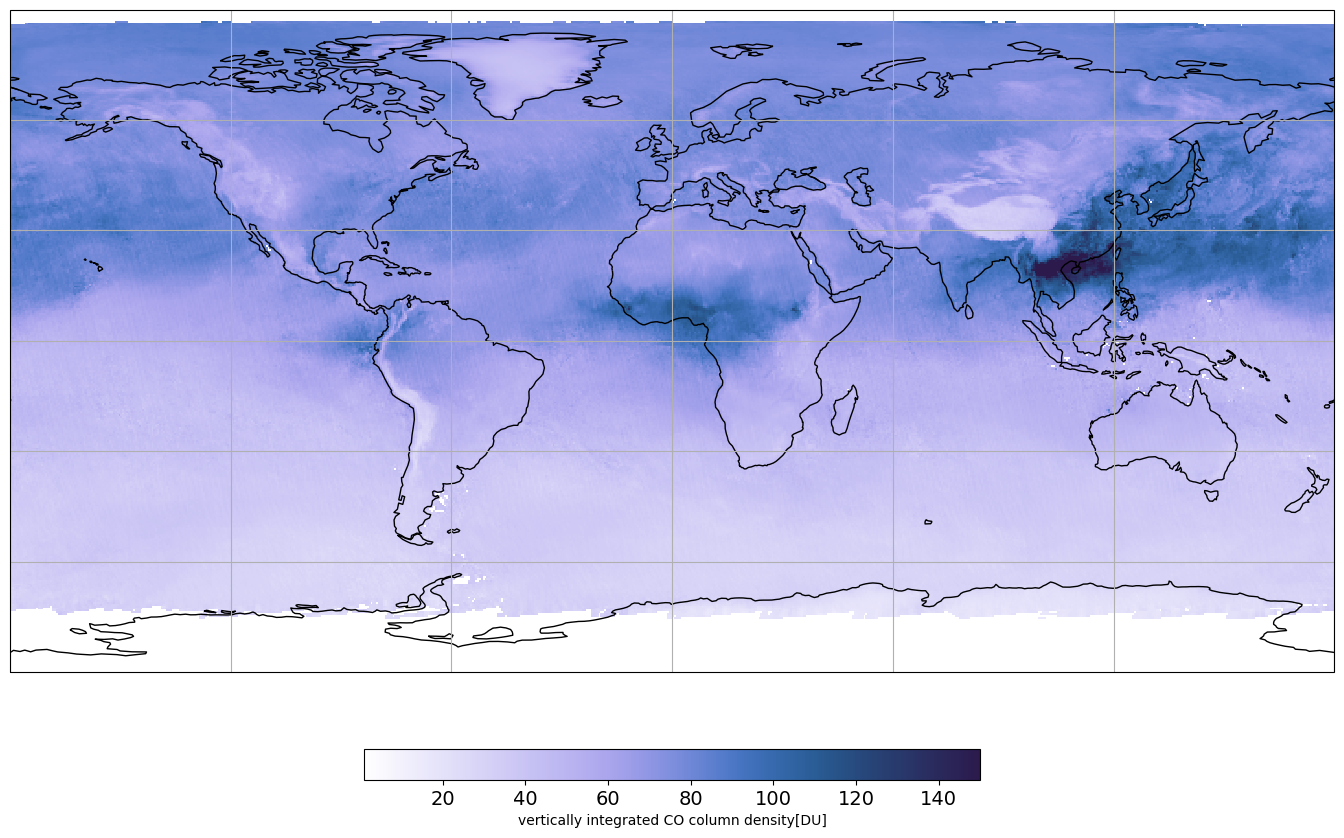

In [79]:
avg_filenames = "./daily_avg/s5p-CO-L3_avg_*.nc"

merged = harp.import_product(filename=avg_filenames, reduce_operations=get_reduce_operations())
merged.latitude_bounds.data[:,:]


gridlat = np.append(merged.latitude_bounds.data[:,0], merged.latitude_bounds.data[-1,1]).flatten()
gridlon = np.append(merged.longitude_bounds.data[:,0], merged.longitude_bounds.data[-1,1]).flatten()
vals = merged.CO_column_number_density.data
units = merged.CO_column_number_density.unit
desc = merged.CO_column_number_density.description

colortable = cm.devon_r

vmin = 1
vmax = 150
merged.CO_column_number_density.data


plot_as_pColormesh(gridlat=gridlat, gridlon=gridlon, vals=vals, vmin=vmin, vmax=vmax, colortable=colortable, desc=desc, units=units)



# Experimential

In [166]:
filename_tropomi = "./daily_avg/s5p-CO-L3_avg_20230401.nc"
operations_trop = ";".join([
    "latitude>47.5",
    "latitude<54",
    "longitude<-8",
    "longitude>-15",
    "keep(latitude_bounds,longitude_bounds,CO_column_number_density)",
    "derive(CO_column_number_density [DU])",
   # "derive(area {time} [km2])",
])
reduce_operations = "bin()"

tropomi_CO = harp.import_product(filename_tropomi, operations=operations_trop)
tropomi_CO

<Product variables=odict_keys(['CO_column_number_density', 'latitude_bounds', 'longitude_bounds'])>

In [137]:
crs = 'epsg:4326'
tropomi = gpd.GeoDataFrame()
tropomi['geometry'] = None
tropomi.crs = crs
x,lat_dim, lon_dim = tropomi_CO.CO_column_number_density.data.shape
#print(lat_dim, " ", lon_dim)
# loop over pixels
for lat_idx in range(lat_dim):
    lat_c = tropomi_CO.latitude_bounds.data[lat_idx]
    for lon_idx in range(lon_dim):
        lon_c = tropomi_CO.longitude_bounds.data[lon_idx]
        coords = [(lat_c[0], lon_c[0]), (lat_c[1], lon_c[0]), (lat_c[1], lon_c[1]), (lat_c[0], lon_c[1])]
        poly = Polygon(coords)
        x = (lat_idx + 1)  * (lon_idx + 1)
        tropomi.loc[x, 'pixel_id'] = x
        tropomi.loc[x, 'geometry'] = poly
        tropomi.loc[x, 'CO'] = np.array(tropomi_CO.CO_column_number_density.data[0][lat_idx][lon_idx])


print(tropomi)  

C:\Users\User\AppData\Local\Temp\ipykernel_11936\424121235.py:3: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  tropomi['geometry'] = None


                                              geometry  pixel_id         CO
1    POLYGON ((47.50000 -15.00000, 48.00000 -15.000...       1.0        NaN
2    POLYGON ((48.00000 -15.00000, 48.50000 -15.000...       2.0        NaN
3    POLYGON ((48.50000 -15.00000, 49.00000 -15.000...       3.0        NaN
4    POLYGON ((49.00000 -15.00000, 49.50000 -15.000...       4.0  89.693489
5    POLYGON ((49.50000 -15.00000, 50.00000 -15.000...       5.0  90.320029
..                                                 ...       ...        ...
144  POLYGON ((53.00000 -9.50000, 53.50000 -9.50000...     144.0  69.705974
156  POLYGON ((53.50000 -9.50000, 54.00000 -9.50000...     156.0  71.296235
168  POLYGON ((53.00000 -8.50000, 53.50000 -8.50000...     168.0  76.047534
169  POLYGON ((53.50000 -9.00000, 54.00000 -9.00000...     169.0  74.170756
182  POLYGON ((53.50000 -8.50000, 54.00000 -8.50000...     182.0  75.444084

[79 rows x 3 columns]


In [139]:
madrid_map = folium.Map(location=[50., -10], zoom_start=8, tiles='Stamen Terrain')

style1 = {'fillColor': 'none', 'color': '#dd3497'}
style2 = {'fillColor': 'none', 'color': '#4a1486'}

folium.GeoJson(tropomi, style_function=lambda x:style1).add_to(madrid_map)
#folium.GeoJson(omi, style_function=lambda x:style2).add_to(madrid_map)
display(madrid_map)